In [1]:
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
mpl.rcParams["figure.figsize"] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [3]:
# preaparing dataset
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)
csv_path, _ = os.path.splitext(zip_path)

13574144/13568290 [==============================] - 13s 1us/step


In [7]:
df = pd.read_csv(csv_path)
df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


In [30]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
    data = []
    labels = []
    
    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size
    
    for i  in range(start_index, end_index):
        indices = range(i-history_size, i)
        # Reshape data from (history_size,) to (history_size, 1)
        data.append(np.reshape(dataset[indices], (history_size, 1)))
        labels.append(dataset[i+target_size])
    return np.array(data), np.array(labels)

In [31]:
TRAIN_SPLIT = 300000
tf.random.set_seed(13)

In [32]:
uni_data = df['T (degC)']
uni_data.index = df['Date Time']
uni_data.head()

Date Time
01.01.2009 00:10:00   -8.02
01.01.2009 00:20:00   -8.41
01.01.2009 00:30:00   -8.51
01.01.2009 00:40:00   -8.31
01.01.2009 00:50:00   -8.27
Name: T (degC), dtype: float64

array([<matplotlib.axes._subplots.AxesSubplot object at 0x00000139C41BD5C0>],
      dtype=object)

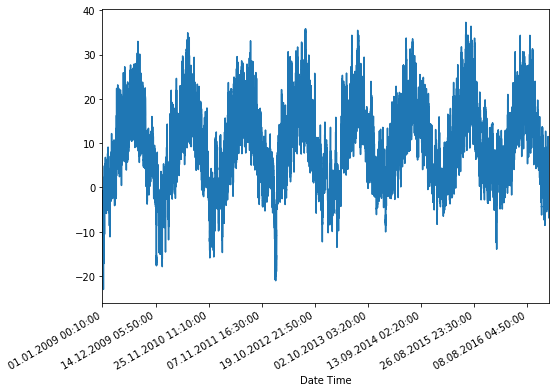

In [33]:
uni_data.plot(subplots=True)

In [34]:
#standardization of uni_data
uni_data = uni_data.values
uni_train_mean = uni_data[:TRAIN_SPLIT].mean()
uni_train_std = uni_data[:TRAIN_SPLIT].std()
uni_data = (uni_data - uni_train_mean) / uni_train_std

In [48]:
univariate_past_history = 20
univariate_future_target = 0
x_train_uni, y_train_uni = univariate_data(uni_data, 0, TRAIN_SPLIT,
                                          univariate_past_history, 
                                          univariate_future_target)
x_val_uni, y_val_uni = univariate_data(uni_data, TRAIN_SPLIT, None, 
                                        univariate_past_history,
                                        univariate_future_target)

In [49]:
print ('Single window of past history')
print (x_train_uni[0])
print ('\n Target temperature to predict')
print (y_train_uni[0])

Single window of past history
[[-1.99766294]
 [-2.04281897]
 [-2.05439744]
 [-2.0312405 ]
 [-2.02660912]
 [-2.00113649]
 [-1.95134907]
 [-1.95134907]
 [-1.98492663]
 [-2.04513467]
 [-2.08334362]
 [-2.09723778]
 [-2.09376424]
 [-2.09144854]
 [-2.07176515]
 [-2.07176515]
 [-2.07639653]
 [-2.08913285]
 [-2.09260639]
 [-2.10418486]]

 Target temperature to predict
-2.1041848598100876


<module 'matplotlib.pyplot' from 'C:\\Users\\user\\AppData\\Roaming\\Python\\Python36\\site-packages\\matplotlib\\pyplot.py'>

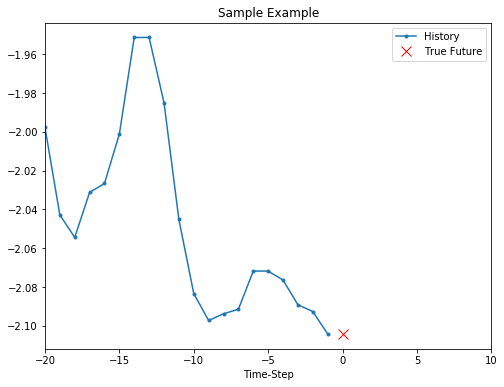

In [50]:
def create_time_steps(length):
    return list(range(-length, 0))

def show_plot(plot_data, delta, title):
    labels = ['History', 'True Future', 'Model Prediction']
    marker = ['.-', 'rx', 'go']
    time_steps = create_time_steps(plot_data[0].shape[0])
    if delta:
        future = delta
    else:
        future = 0
    
    plt.title(title)
    for i, x in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10,
                   label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future+5)*2])
    plt.xlabel('Time-Step')
    return plt

show_plot([x_train_uni[0], y_train_uni[0]], 0, 'Sample Example')

<module 'matplotlib.pyplot' from 'C:\\Users\\user\\AppData\\Roaming\\Python\\Python36\\site-packages\\matplotlib\\pyplot.py'>

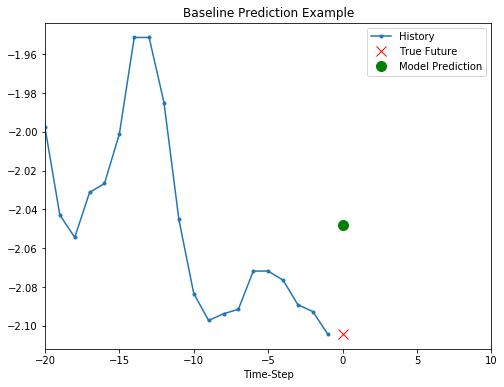

In [51]:
def baseline(history):
    return np.mean(history)

show_plot([x_train_uni[0], y_train_uni[0], baseline(x_train_uni[0])], 0,
           'Baseline Prediction Example')

# Recurrent neural network

In [52]:
BATCH_SIZE = 256 
BUFFER_SIZE = 10000

train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

In [63]:
simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(8, input_shape=x_train_uni.shape[-2:]),
    tf.keras.layers.Dense(1)
])

simple_lstm_model.compile(optimizer='adam', loss='mae')

In [66]:
#check the output model
for x, y in val_univariate.take(1):
    print(simple_lstm_model.predict(x).shape)

(256, 1)


In [75]:
#train the model
EVALUATEION_INTERVAl = 200
EPOCHS = 10
simple_lstm_model.fit(train_univariate, epochs=EPOCHS, 
                     steps_per_epoch = EVALUATEION_INTERVAl,
                     validation_data = val_univariate, validation_steps=50)

Train for 200 steps, validate for 50 steps
Epoch 1/10
200/200 [==============================] - 2s 8ms/step - loss: 0.0160 - val_loss: 0.0126
Epoch 2/10
200/200 [==============================] - 2s 8ms/step - loss: 0.0159 - val_loss: 0.0122
Epoch 3/10
200/200 [==============================] - 2s 8ms/step - loss: 0.0161 - val_loss: 0.0123
Epoch 4/10
200/200 [==============================] - 2s 8ms/step - loss: 0.0156 - val_loss: 0.0121
Epoch 5/10
200/200 [==============================] - 2s 8ms/step - loss: 0.0138 - val_loss: 0.0121
Epoch 6/10
200/200 [==============================] - 2s 8ms/step - loss: 0.0158 - val_loss: 0.0126
Epoch 7/10
200/200 [==============================] - 2s 8ms/step - loss: 0.0152 - val_loss: 0.0123
Epoch 8/10
200/200 [==============================] - 2s 8ms/step - loss: 0.0153 - val_loss: 0.0126
Epoch 9/10
200/200 [==============================] - 2s 9ms/step - loss: 0.0158 - val_loss: 0.0119
Epoch 10/10
200/200 [==============================] - 2s

In [89]:
# simple_lstm_model.predict(x_val_uni[0])

In [88]:
# predictions  = simple_lstm_model.predict(val_univariate)
# predictions
# # print(tf.keras.metrics.Accuracy(val_univariate, predictions))

In [90]:
# x, y = val_univariate.take(1)

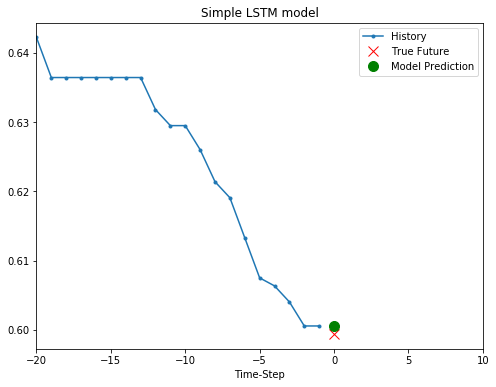

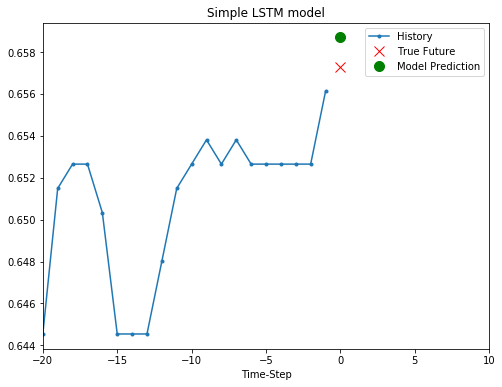

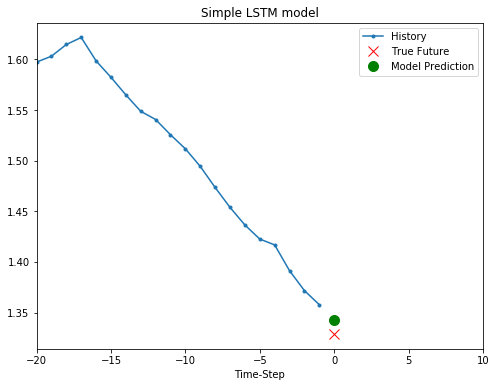

In [91]:
for x, y in val_univariate.take(3):
    plot = show_plot([x[0].numpy(), y[0].numpy(), simple_lstm_model.predict(x)[0]], 0, 'Simple LSTM model')
    plt.show()

# Forecast a multivariate time series

In [101]:
features_considered = ['p (mbar)', 'T (degC)', 'rho (g/m**3)']
features = df[features_considered]
features.index = df['Date Time']
features.head()

,p (mbar),T (degC),rho (g/m**3)
Date Time,,,
01.01.2009 00:10:00,996.52,-8.02,1307.75
01.01.2009 00:20:00,996.57,-8.41,1309.80
01.01.2009 00:30:00,996.53,-8.51,1310.24
01.01.2009 00:40:00,996.51,-8.31,1309.19
01.01.2009 00:50:00,996.51,-8.27,1309.00


In [102]:
dataset = df[features_considered].values
data_mean = dataset[: TRAIN_SPLIT].mean(axis=0)
data_std = dataset[: TRAIN_SPLIT].std(axis=0)

dataset = (dataset - data_mean) / data_std

In [103]:
def multivariate_data(dataset, target, start_index, end_index, history_size, 
                     target_size, step, single_step=False):
    data = []
    labels = []
    
    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size
    
    for i  in range(start_index, end_index):
        indices = range(i-history_size, i, step)
        data.append(dataset[indices])
        
        if single_step:
            labels.append(target[i+target_size])
        else:
            labels.append(target[i:i+target_size])
    return np.array(data), np.array(labels)

In [105]:
past_history = 720
future_target = 72
STEP=6

x_train_single, y_train_single = multivariate_data(dataset, dataset[:, 1], 0, TRAIN_SPLIT,
                                                   past_history, future_target, STEP, single_step=True)
x_val_single, y_val_single = multivariate_data(dataset, dataset[:, 1], TRAIN_SPLIT, None, 
                                               past_history, future_target, STEP, single_step=True)

print("Single windows of past history {}".format(x_train_single[0].shape))

Single windows of past history (120, 3)


In [119]:
train_data_single = tf.data.Dataset.from_tensor_slices((x_train_single, y_train_single))
train_data_single = train_data_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_single = tf.data.Dataset.from_tensor_slices((x_val_single, y_val_single))
val_data_single = val_data_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

In [120]:
single_step_model = tf.keras.models.Sequential()
single_step_model.add(tf.keras.layers.LSTM(32, input_shape = x_train_single.shape[-2:]))
single_step_model.add(tf.keras.layers.Dense(1))
single_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mae')

In [121]:
for x, y in val_data_single.take(1):
    print(single_step_model.predict(x).shape)

(256, 1)


In [122]:
single_step_history = single_step_model.fit(train_data_single, epochs=EPOCHS, 
                                           steps_per_epoch = EVALUATEION_INTERVAl,
                                           validation_data = val_data_single,
                                           validation_steps=50)

Train for 200 steps, validate for 50 steps
Epoch 1/10
200/200 [==============================] - 54s 271ms/step - loss: 0.3090 - val_loss: 0.2808
Epoch 2/10
200/200 [==============================] - 58s 289ms/step - loss: 0.2593 - val_loss: 0.2547
Epoch 3/10
200/200 [==============================] - 63s 316ms/step - loss: 0.2610 - val_loss: 0.2606
Epoch 4/10
200/200 [==============================] - 69s 347ms/step - loss: 0.2559 - val_loss: 0.2366
Epoch 5/10
200/200 [==============================] - 76s 381ms/step - loss: 0.2257 - val_loss: 0.2378
Epoch 6/10
200/200 [==============================] - 84s 422ms/step - loss: 0.2400 - val_loss: 0.2702
Epoch 7/10
200/200 [==============================] - 88s 439ms/step - loss: 0.2406 - val_loss: 0.2574
Epoch 8/10
200/200 [==============================] - 87s 435ms/step - loss: 0.2413 - val_loss: 0.2570
Epoch 9/10
200/200 [==============================] - 85s 427ms/step - loss: 0.2433 - val_loss: 0.2489
Epoch 10/10
200/200 [=========

In [125]:
def plot_train_history(history, title):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    epochs = range(len(loss))
    
    plt.figure()
    plt.plot(epochs, loss, 'b',label='Training oss')
    plt.plot(epochs, val_loss, 'r',label='Validation loss')
    plt.title(title)
    plt.legend()
    plt.show()

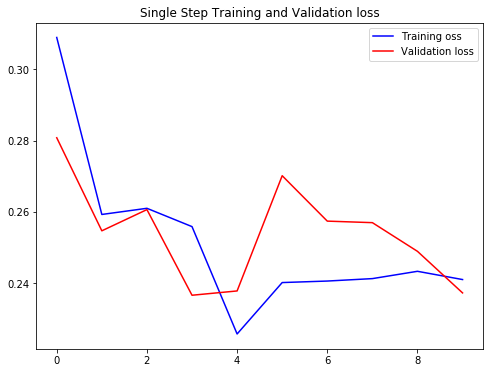

In [126]:
plot_train_history(single_step_history, "Single Step Training and Validation loss")

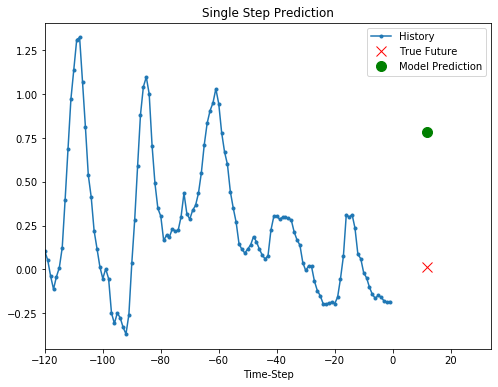

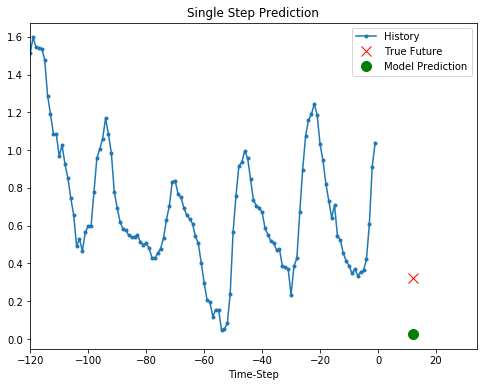

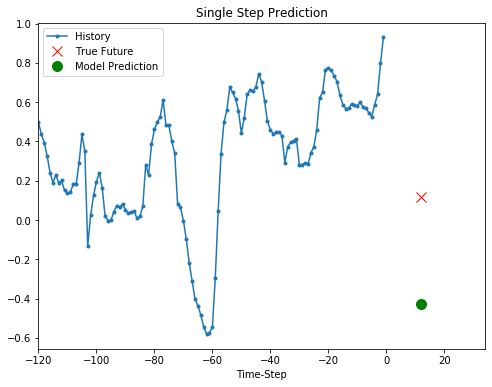

In [128]:
for x, y in val_data_single.take(3):
    plot = show_plot([x[0][:, 1].numpy(), y[0].numpy(), 
                     single_step_model.predict(x)[10]], 12,
                    'Single Step Prediction')
    plot.show()

In [129]:
future_target = 72
x_train_multi, y_train_multi = multivariate_data(dataset, dataset[:, 1], 0,
                                                 TRAIN_SPLIT, past_history,
                                                 future_target, STEP)
x_val_multi, y_val_multi = multivariate_data(dataset, dataset[:, 1],
                                             TRAIN_SPLIT, None, past_history,
                                             future_target, STEP)

train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

In [130]:
def multi_step_plot(history, true_future, prediction):
    plt.figure(figsize=(12, 6))
    num_in = create_time_steps(len(history))
    num_out = len(true_future)

    plt.plot(num_in, np.array(history[:, 1]), label='History')
    plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',
           label='True Future')
    if prediction.any():
        plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',
             label='Predicted Future')
    plt.legend(loc='upper left')
    plt.show()

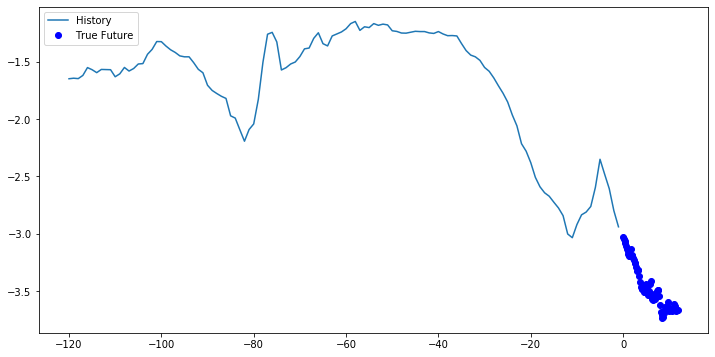

In [133]:
for x, y in train_data_multi.take(1):
    multi_step_plot(x[0], y[0], np.array([0]))

In [135]:
multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.LSTM(32,
                                          return_sequences=True,
                                          input_shape=x_train_multi.shape[-2:]))
multi_step_model.add(tf.keras.layers.LSTM(16, activation='relu'))
multi_step_model.add(tf.keras.layers.Dense(72))

multi_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')

In [137]:
multi_step_history = multi_step_model.fit(train_data_multi, epochs=EPOCHS,
                                          steps_per_epoch=EVALUATEION_INTERVAl,
                                          validation_data=val_data_multi,
                                          validation_steps=50)

Train for 200 steps, validate for 50 steps
Epoch 1/10
200/200 [==============================] - 95s 473ms/step - loss: 2.0991 - val_loss: 0.4304
Epoch 2/10
200/200 [==============================] - 88s 439ms/step - loss: 0.9785 - val_loss: 0.3932
Epoch 3/10
200/200 [==============================] - 98s 488ms/step - loss: 0.4657 - val_loss: 0.3148
Epoch 4/10
200/200 [==============================] - 106s 531ms/step - loss: 0.3682 - val_loss: 0.2792
Epoch 5/10
200/200 [==============================] - 110s 551ms/step - loss: 0.2836 - val_loss: 0.2676
Epoch 6/10
200/200 [==============================] - 112s 558ms/step - loss: 45.6492 - val_loss: 0.2273
Epoch 7/10
200/200 [==============================] - 110s 552ms/step - loss: 0.2435 - val_loss: 0.2170
Epoch 8/10
200/200 [==============================] - 113s 563ms/step - loss: 0.2267 - val_loss: 0.2010
Epoch 9/10
200/200 [==============================] - 110s 549ms/step - loss: 0.2229 - val_loss: 0.2056
Epoch 10/10
200/200 [==

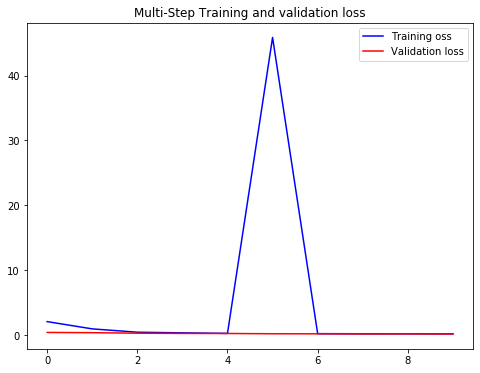

In [138]:
plot_train_history(multi_step_history, 'Multi-Step Training and validation loss')

In [ ]:
for x, y in val_data_multi.take(3):
    multi_step_plot(x[0], y[0], multi_step_model.predict(x)[0])